# Phugoid Oscillations - Summary of Described Methods

Having developed the equations, we need to implement the following algorith:
$$\begin{eqnarray}
z_{n+1} = z_n + \Delta t * b_n \\
b_{n+1} = b_n + \Delta t * (g - (g/z_t)z_n)
\end{eqnarray}$$

Which comes directly from the re-arrange definition of derivative, considering $\Delta t$ to be small enough:
$\begin{equation}
\vec{u}(t+\Delta t) = \vec{u}(t)  + \vec{u}'(t)\Delta t
\end{equation}$

In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline

First we define the iteration parameters and discretise the time domain based on these.

In [2]:
T = 100.
dt = 0.02
N = int(T/dt)+1
t = np.linspace(0.0, T, N)

Definition of the initial conditions $z_o$ and $b_o$, the constants $z_t$ and $g$, and the $u$ array that will hold the instantaneous values of $z$ and $b$ for each time step. We remember that this array comes from the vector notation:

$$\begin{equation}
\vec{u}  = \begin{pmatrix} z \\ b \end{pmatrix}
\end{equation}$$

In [3]:
z0 = 100.
b0 = 10.
zt = 100.
g = 9.81
u = np.array([z0,b0])

Now we define the vector that will hold all the z values, i.e., the position of the aircraft:

In [4]:
z = np.zeros(N)
z[0] = z0
b = np.zeros(N)
b[0] = b0

Implementing the alrgorith described above:

In [5]:
for n in range(1,N):
    u = u + dt*np.array([u[1],g*(1-u[0]/zt)])
    z[n] = u[0]
    b[n] = u[1]

Important to mention here: We run a ``for``-loop where the vector $\vec{u}$ changes in every step, but its first component is sored in $\vec{z}$. An interest addition I will make is an extra vecotr, one that holds the second component of $\vec{u}$, which is interpreted as the instantaneous velocity.

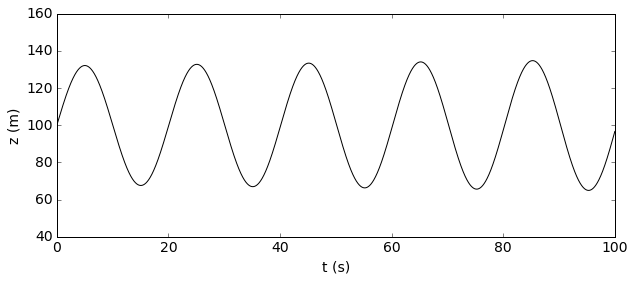

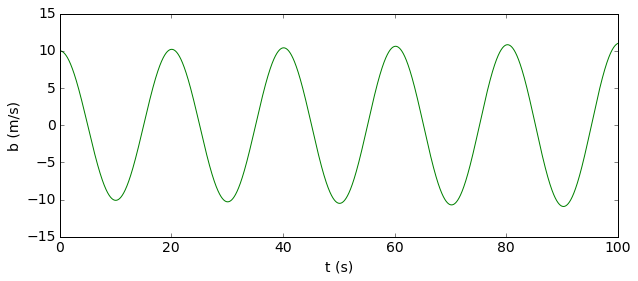

In [6]:
pyplot.figure(figsize=(10,4))   #set plot size
pyplot.ylim(40,160)             #y-axis plot limits
pyplot.tick_params(axis='both', labelsize=14) #increase font size for ticks
pyplot.xlabel('t (s)', fontsize=14) #x label
pyplot.ylabel('z (m)', fontsize=14) #y label
pyplot.plot(t,z, 'k-');

pyplot.figure(figsize=(10,4))   #set plot size
pyplot.ylim(-15,15)             #y-axis plot limits
pyplot.tick_params(axis='both', labelsize=14) #increase font size for ticks
pyplot.xlabel('t (s)', fontsize=14) #x label
pyplot.ylabel('b (m/s)', fontsize=14) #y label
pyplot.plot(t,b, 'g-');

Precisely what we were expecting from the initial conditions and the already known shape of the curves for simple harmonic motion.

## Analytical Solution

The exact solution is:

$$\begin{equation}
z(t) = A\sin\left(\sqrt{\frac{g}{z_t}}t\right) + B\cos\left(\sqrt{\frac{g}{z_t}}t\right) + z_t
\end{equation}$$

Which, taking into account the initial conditions, turns out to be:

$$\begin{equation}
z(t) = b_o\sqrt{\frac{z_t}{g}}\sin\left(\sqrt{\frac{g}{z_t}t}\right) + (z_o - z_t)\cos\left(\sqrt{\frac{g}{z_t}t}\right) + z_t
\end{equation}$$

## Convergence

In order to quantify the error, we compare the exact solution with the numerical one. We use a norm of the difference:

$$\begin{equation}
E = \Delta t \sum_{n=1}^{N}|z(t_n)-z_n|
\end{equation}$$

$E$ in this case would only show the commulated error. By changing the dt and calculating a new value of $E$ we could compare and decide when the resolution does not affect the numerical result. In other words, we are doing a grid independency analysis.

We want to define a new vector containing different values of $\Delta$ and a new matrix holding the different solutions of $z$ for each $\Delta$. This new array will have as each entry the array z defined previously; hence, it's size must be the same as the size of the array holding the different $\Delta$ values.

In [8]:
# Definining the different values for dt
dt_values = np.array([0.1, 0.05, 0.01, 0.005, 0.001, 0.0001])

# Array containing the z solutions for each dt (for each grid).
z_values = np.empty_like(dt_values, dtype=np.ndarray)

Now, a `for` loop with an `enumerate` function will iterate through the objects inside the enumerate considering an index for each one of them. We can implement Euler's method with each $\Delta$ value and the result 'add' it to the `z_values` array using the indexes of each $\Delta$ as follow:

In [11]:
for i, dt in enumerate(dt_values):
    N = int(T/dt)+1  #Number of time-steps
    t = np.linspace(0.0, T, N)
    
    # initila conditions
    u = np.array([z0, b0])
    z = np.empty_like(t)
    z[0] = z0
    
    # time loop
    for n in range(1,N):
        u = u +dt*np.array([u[1], g*(1-u[0]/zt)])
        z[n] = u[0]
        
    z_values[i] = z.copy()

The error $E$ can be define inside a function. A discretisation is needed for the exact solution as well, because we want to compare each $z$ at the same instant $t$. The error is calculated with an array sum, i.e., each entry `i` of the vector `z` is sum with each entry `i` of the newly calculated vector `z_exact`, that would hold the exact solutions for each time-step. The result is an array holding an scalar $E$ for each time-step.

In [18]:
def get_error(z, dt):
    N = len(z)
    t = np.linspace(0.0, T, N)
    
    z_exact = b0*(zt/g)**.5*np.sin((g/zt)**.5*t)+\
    (z0-zt)*np.cos((g/zt)**.5*t)+zt
    
    return dt*np.sum(np.abs(z-z_exact))

Now, we can define a new array `error_values`, which will hold an array of $E$ for each value of $\Delta$

In [19]:
error_values=np.empty_like(dt_values)

for i, dt in enumerate(dt_values):
    error_values[i] = get_error(z_values[i], dt)

(0.0001, 0.10000000000000001, 0.10000000000000001, 1000.0)

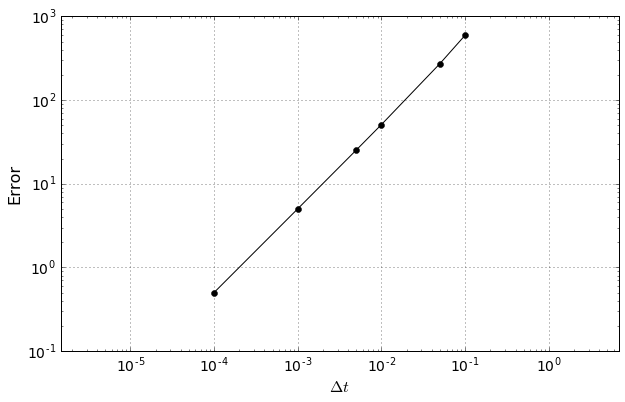

In [20]:
pyplot.figure(figsize=(10, 6))
pyplot.tick_params(axis='both', labelsize=14) #increase tick font size
pyplot.grid(True)                         #turn on grid lines
pyplot.xlabel('$\Delta t$', fontsize=16)  #x label
pyplot.ylabel('Error', fontsize=16)       #y label
pyplot.loglog(dt_values, error_values, 'ko-')  #log-log plot
pyplot.axis('equal')                      #make axes scale equally;

It is clear how the error decreases when the $\Delta t$ decreases as well. It seems to be no plateau, in this particular problem.

# Challenge!
Create a function that implements Euler's method and re-write the error analysis cell to use your function.
We want to re-use code (an not just copy and paste).

In [21]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [1]:
import numpy as np
from matplotlib import pyplot
%matplotlib inline